Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [44]:
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator


Internal Libraries:

In [23]:
# Internal libraries:
from load_images import load_images

from preprocessing import multiple_dataset_conversion

from plotting import plot_image_classes
from plotting import plot_cnn_history
from plotting import plot_image


from Models.VGG16 import build_cnn
from Models.VGG16 import train_cnn


Load images from the dataset

In [14]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

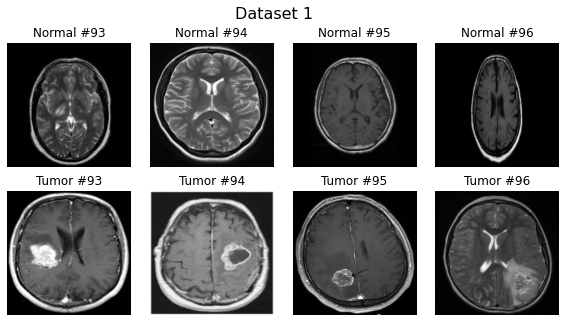

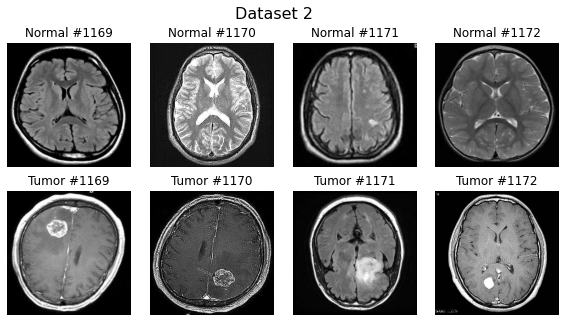

In [15]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

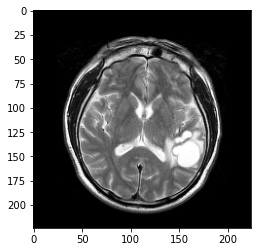

/var/folders/cn/b7hd5xd92dx4l2mj48c08x440000gn/T/ipykernel_47548/2213174233.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(set_new)


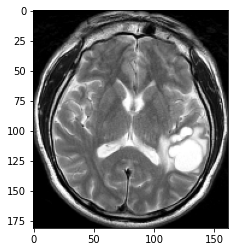

In [53]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


plot_image(dataset_1_tumor_images[4])
dataset_1_tumor_images_proc = crop_imgs(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_imgs(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_imgs(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_imgs(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image)

In [54]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

dataset_1_normal_images_proc = preprocess_imgs(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_imgs(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_imgs(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_imgs(dataset_2_tumor_images_proc, (224, 224))


Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [55]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

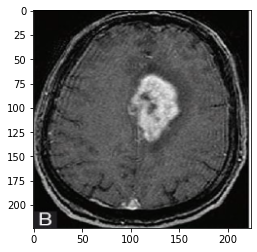

In [81]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0])

Preform some data augmentation on the training data

In [84]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


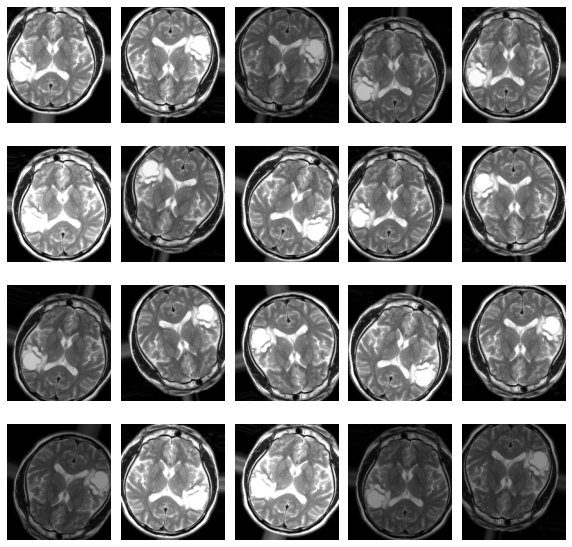

In [99]:
# Example of augmentation:

augmented_test_image = test_image
augmented_test_image = augmented_test_image.reshape((1,)+augmented_test_image.shape)
examples = 0


# Create a 4x5 grid of augmented images
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
# Remove horizontal space between axs
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for batch in example_datagen.flow(augmented_test_image, batch_size=1):
    coord = examples // 5, examples % 5
    axs[coord].imshow(batch[0])
    axs[coord].axis('off')

    examples += 1
    if examples >= 20:
        break

# Remove whitespace horizontally and vertically

fig.savefig('./Figures/augmented_images.png')


In [96]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

augment_limit = 10

augmented_train_images = []
augmented_test_images = []
augmented_val_images = []

augmented_light_train_images = []
augmented_light_test_images = []
augmented_light_val_images = []

for image in X_train:
    for batch in train_datagen.flow(image.reshape((1,)+image.shape), batch_size=1):
        augmented_train_images.append(batch[0])
        

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (224, 224, 3), y.shape = (2602,)